In [87]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os 
import pandas as pd
from matplotlib.lines import Line2D
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [2]:
print(os.listdir(os.path.join(os.getcwd(),"ExperimentLogs")))

['debug', 'Final', 'Final100', 'Final_f', 'Final_h', 'info.txt']


In [88]:
last_exp = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\Final100"

In [89]:
def load_all_pickles(directory:str, model: str, graphtype: str, num_obs:int=100) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: 
    :param model: 
    :param graphtype: 
    :param num_obs: 
    :return: 
    """
    loaded_objects = []
    final_path = os.path.join(directory, model, graphtype)
    
    for i, filename in enumerate(os.listdir(final_path)):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
        if i == num_obs - 1:
            return loaded_objects
        
    return loaded_objects
    

## Store the results of all Model/Scenario Combinations 

In [90]:
# Graphtype must match with the names specified in config.py 
gcn_perfect = load_all_pickles(last_exp, "GCN", "perfect")
gat_perfect = load_all_pickles(last_exp, "GAT", "perfect")
sage_perfect = load_all_pickles(last_exp, "SAGE", "perfect")
#XG_perfect = load_all_pickles(last_exp, "XGBOOST", "perfect")
mlp_perfect = load_all_pickles(last_exp, "MLP", "perfect")

gcn_com = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant")
gat_com = load_all_pickles(last_exp, "GAT", "community_relevant")
sage_com = load_all_pickles(last_exp, "SAGE", "community_relevant")
#XG_com = load_all_pickles(last_exp, "XGBOOST", "community_relevant")
mlp_com = load_all_pickles(last_exp, "MLP", "community_relevant")

gcn_com_h = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_heterophilic")
gat_com_h = load_all_pickles(last_exp, "GAT", "community_relevant_heterophilic")
sage_com_h = load_all_pickles(last_exp, "SAGE", "community_relevant_heterophilic")
#XG_com_h = load_all_pickles(last_exp, "XGBOOST", "community_relevant_heterophilic")
mlp_com_h = load_all_pickles(last_exp, "MLP", "community_relevant_heterophilic")


gcn_feat = load_all_pickles(directory=last_exp,model="GCN",graphtype="cluster_relevant")
gat_feat = load_all_pickles(last_exp, "GAT", "cluster_relevant")
sage_feat = load_all_pickles(last_exp, "SAGE", "cluster_relevant")
#XG_feat = load_all_pickles(last_exp, "XGBOOST", "cluster_relevant")
mlp_feat = load_all_pickles(last_exp, "MLP", "cluster_relevant")

gcn_feat_p = load_all_pickles(directory=last_exp,model="GCN",graphtype="non_seperated_cluster_relevant")
gat_feat_p = load_all_pickles(last_exp, "GAT", "non_seperated_cluster_relevant")
sage_feat_p = load_all_pickles(last_exp, "SAGE", "non_seperated_cluster_relevant")
#XG_feat_p = load_all_pickles(last_exp, "XGBOOST", "non_seperated_cluster_relevant")
mlp_feat_p = load_all_pickles(last_exp, "MLP", "non_seperated_cluster_relevant")

gcn_noise = load_all_pickles(directory=last_exp,model="GCN",graphtype="noise")
gat_noise = load_all_pickles(last_exp, "GAT", "noise")
sage_noise = load_all_pickles(last_exp, "SAGE", "noise")
#XG_noise = load_all_pickles(last_exp, "XGBOOST", "noise")
mlp_noise = load_all_pickles(last_exp, "MLP", "noise")


In [91]:
package = np.array([[gcn_perfect, gcn_com, gcn_com_h,
                     gcn_feat, gcn_feat_p, gcn_noise],  
                    [gat_perfect, gat_com, gat_com_h, 
                     gat_feat, gat_feat_p, gat_noise],  
                    [sage_perfect, sage_com, sage_com_h,
                     sage_feat, sage_feat_p, sage_noise],  
                    [mlp_perfect, mlp_com, mlp_com_h,
                     mlp_feat, mlp_feat_p, mlp_noise]])

n_scenarios = package.shape[1]
print(n_scenarios)

colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"]
#colors = ["forestgreen", "royalblue", "dodgerblue", "mediumslateblue", "orange", "goldenrod", "firebrick"]


6


# Plot 

In [121]:
def plot_with_confidence_interval(target, color, add_final_epoch, key="loss_track", empirical_CI=True, ax=None, percentiles=5):
    """
    Plots figure for one Scenario in specified axis.
    :param target: Results of the scenario.
    :param color: Color for scenario mapping.
    :param key: Key to extract values from target.
    :param empirical_CI: Boolean to use empirical confidence interval.
    :param ax: Axis object to plot on.
    :return: None
    """
    ys = np.array([lp[key] for lp in target])  # loss-values @ epoch
    
    #final_epochs = np.array([None if lp["final_epoch"] == 100 else lp["final_epoch"] for lp in target])  # 100 equivalent to NONE 
    final_epochs = [lp["final_epoch"] for lp in target]
    nna = sum([0 if x else 1 for x in final_epochs])
    avg_final_epoch = np.nanmean(final_epochs)
    
    mean_ys = np.mean(ys, axis=0)
    std_ys = np.sqrt(np.var(ys, axis=0)) 

    if empirical_CI:
        ci_lower = np.percentile(ys, percentiles, axis=0)
        ci_upper = np.percentile(ys, (100-percentiles), axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(len(mean_ys))
    ax.plot(x, mean_ys, color=color, linewidth=1.5)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.1) if empirical_CI==True else None
    if add_final_epoch == "loss_track":
        ax.axvline(x=avg_final_epoch, color=color, linestyle='--')
    
    return avg_final_epoch, nna


def plot_cumulated_time(target, color, empirical_CI=True, percentiles=5):
    ys = np.array([lp["epoch_times"] for lp in target])  # loss-values @ epoch
    #mean_ys = np.cumsum(np.mean(ys, axis=0))
    mean_ys = np.mean(ys, axis=0)

    std_ys = np.sqrt(np.var(ys, axis=0))

    if empirical_CI:
        ci_lower = np.percentile(ys, percentiles, axis=0)
        ci_upper = np.percentile(ys, (100-percentiles), axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(len(mean_ys))
    final_avg = np.mean(mean_ys)
    ax.plot(x, mean_ys, color=color, linewidth=1.5)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.1) if empirical_CI==True else None
    ax.axhline(y=final_avg, color=color, linestyle='--', linewidth=.5)
    
    return final_avg


### Loss/Validation Accuracy - Curves

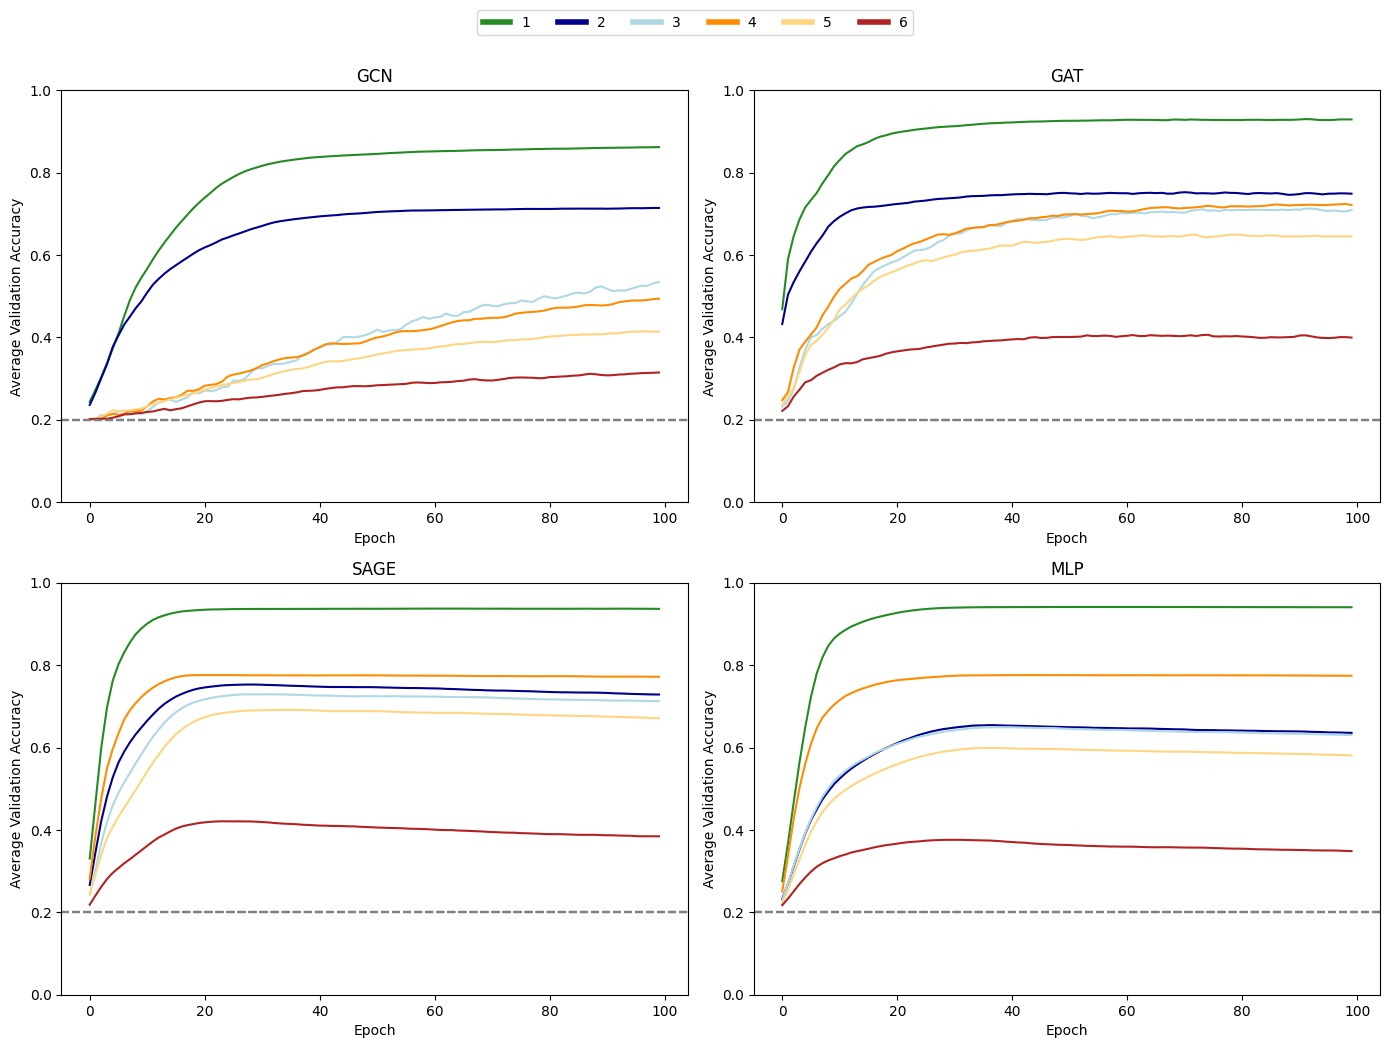

array([[93.95, 88.34, 84.11, 83.62, 86.18, 70.8 , 84.5 ],
       [87.74, 87.16, 83.42, 91.16, 79.24, 75.62, 84.06],
       [57.58, 53.37, 60.94, 44.8 , 62.06, 53.17, 55.32],
       [53.94, 65.68, 67.7 , 47.79, 69.43, 57.6 , 60.36],
       [73.3 , 73.64, 74.04, 66.84, 74.23, 64.3 ,  0.  ]])

In [125]:
#l_o_a = "loss_track"  
l_o_a = "val_acc_track"
#l_o_a = "time"

arch = ["GCN", "GAT", "SAGE", "MLP"]
colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

early_stops = np.zeros((5, n_scenarios + 1))
 
NNA = np.zeros((5, n_scenarios + 1))
labels = np.arange(n_scenarios) + 1

for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        if l_o_a in ["val_acc_track","loss_track"]:
            early_stops[i, j], NA = plot_with_confidence_interval(target, color, key=l_o_a,
                                                                  empirical_CI=False, ax=ax, percentiles=5,
                                                                  add_final_epoch=l_o_a)
        else:
            early_stops[i, j] = plot_cumulated_time(target, color, empirical_CI=False)  # name missused
        
        ax.axhline(y=0.2, color='grey', linestyle='--') if l_o_a == "val_acc_track" else None
        ax.plot([], [], color=color, label=label)  

    ax.set_xlabel('Epoch')
    if l_o_a == "loss_track":
        ax.set_ylabel('Average Loss')
    elif l_o_a == "val_acc_track":
        ax.set_ylabel('Average Validation Accuracy')
    else:
        ax.set_ylabel('Average Validation Accuracy')
        
        
    ax.set_ylim(0, 1) if l_o_a == "val_acc_track" else None#ax.set_ylim(0, 4000) 
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]  # Farben unterscheiden 
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

early_stops[-1,0:-1] = np.mean(early_stops[:-1, :-1], axis=0)  # row-wise average
early_stops[0:-1,-1] = np.mean(early_stops[:-1,:-1], axis=1)  # col-wise average

plt.tight_layout()
plt.show()

#np.round(early_stops, 2)
np.round(early_stops, 2)


#  GCN könnte mehr epochs vertragen !!
# Erwartungswert von random guess (Wahrscheinlichkeit) 600/3000
# Zeit pro Epoche -> Zeitvergleich 


### Test accs 

In [126]:
mus = np.zeros((4, n_scenarios))  # models (i) x scenarios (j)
sigs = np.empty((4, n_scenarios), dtype="U64")  
upper_lower = lambda x, p : (round(np.percentile(x, p, axis=0), 3), round(np.percentile(x, 100-p, axis=0), 3))
normal = np.empty((4, n_scenarios), dtype="U8")  

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6, 7]
        accs = [acc["test_accuracy"] for acc in scen]
        
        mus[i, j] += np.round(np.mean(accs), 3)
        #sigs[i, j] += np.round(np.sqrt(np.var(accs)), 3)
        sigs[i, j] = str(upper_lower(accs, 5))
        _, p = stats.shapiro(accs)
        normal[i, j] = "*" if p < .05 else ""
        
result = np.array([[f'{a} {b} {c}' for a, b, c in zip(row_A, row_B, row_C)]
                   for row_A, row_B, row_C in zip(mus, sigs, normal)])        

result = pd.DataFrame(result,
                      index=["GCN", "GAT","SAGE","MLP"],
                      columns=["Perfect", "com", "com_h",
                               "feat", "feat_p", "noise"])
result
#normal < .05

,Perfect,com,com_h,feat,feat_p,noise
GCN,"0.858 (0.828, 0.893)","0.712 (0.672, 0.755)","0.487 (0.223, 0.66) *","0.449 (0.226, 0.594) *","0.388 (0.216, 0.477) *","0.29 (0.196, 0.372)"
GAT,"0.927 (0.902, 0.954) *","0.751 (0.699, 0.815) *","0.704 (0.611, 0.784) *","0.714 (0.598, 0.785) *","0.641 (0.558, 0.72)","0.399 (0.33, 0.458)"
SAGE,"0.936 (0.913, 0.958)","0.747 (0.695, 0.799)","0.725 (0.663, 0.798)","0.771 (0.72, 0.817)","0.682 (0.62, 0.735)","0.408 (0.348, 0.477)"
MLP,"0.939 (0.915, 0.962)","0.648 (0.568, 0.732)","0.639 (0.556, 0.725)","0.771 (0.722, 0.815)","0.589 (0.51, 0.66)","0.366 (0.31, 0.425)"


In [137]:
np.mean(mus[0:3, 1]-mus[-1,1])

0.08866666666666663

In [21]:
l1 = [s["test_accuracy"] for s in gat_com]
l2 = [s["test_accuracy"] for s in gat_com_h]

#stat, p_value = mannwhitneyu(l1, l2, alternative='two-sided')
stat, p_value = ttest_ind(l1, l2, equal_var=False)

alpha = 0.01  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: The two lists have significantly different means.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the means.")

Reject the null hypothesis: The two lists have significantly different means.


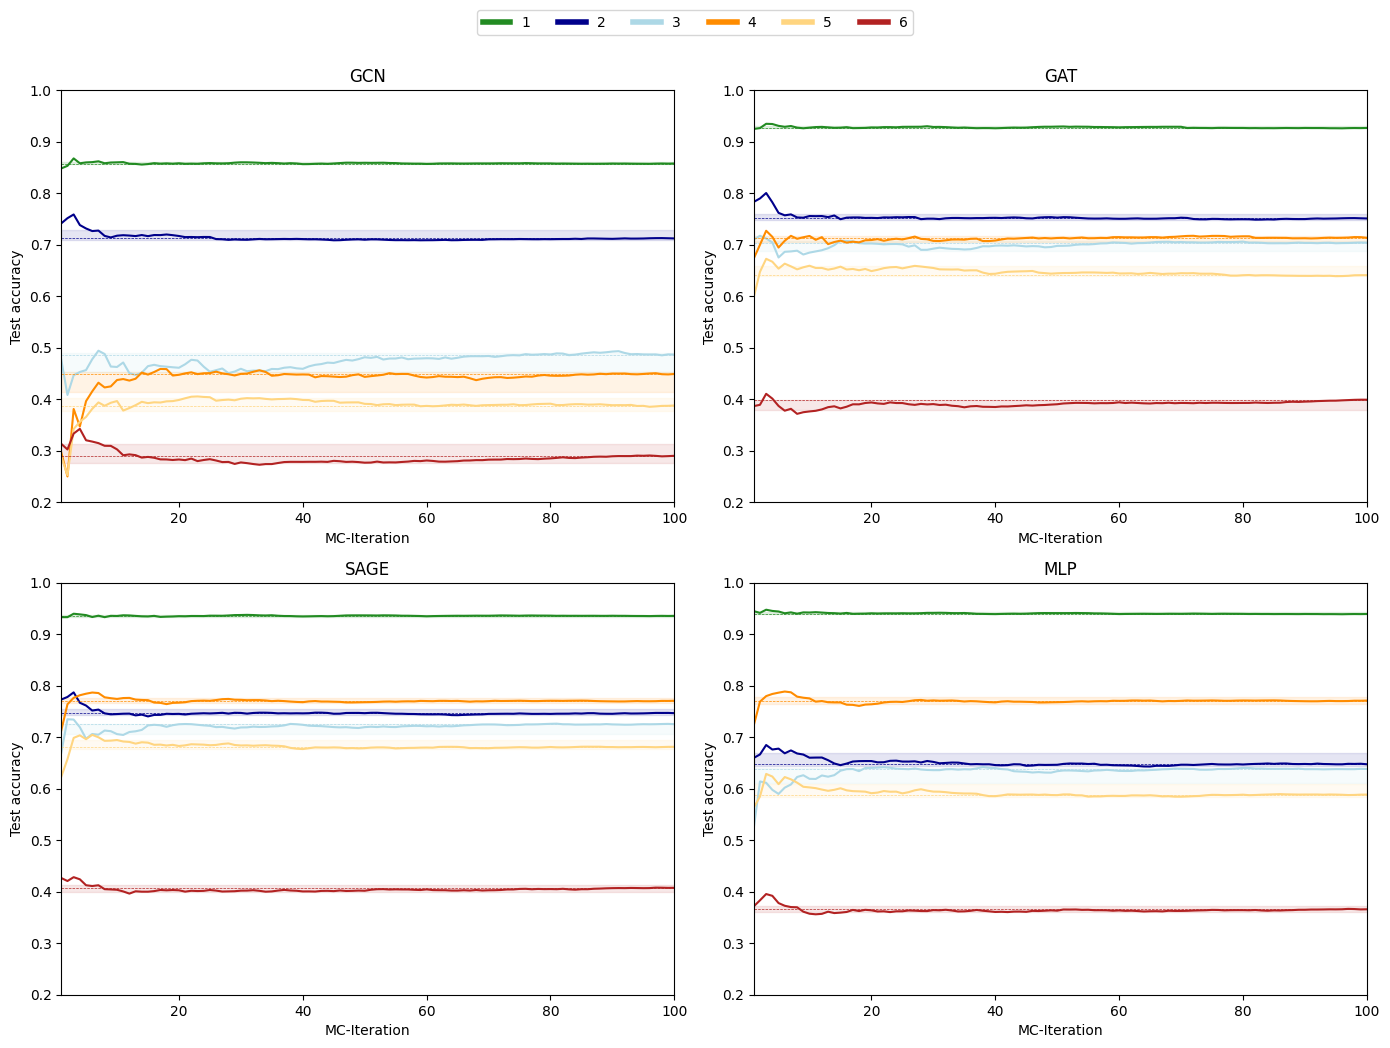

array([[30., 24., 32., 81., 48., 34.],
       [22., 17., 71., 38., 11., 24.],
       [ 1., 16., 69., 32., 52., 14.],
       [22., 11., 30., 14., 35., 24.]])

In [138]:
def MC_check_convergence(x: any, eps: float) -> int | None: 
    """
    
    :param x: 1 dimensional array
    :param eps: stoppage criterion 
    :return: Index of convergence, or None if not converged  
    """
    for i in range(len(x) - 1):
        if abs(x[i+1] - x[i]) < eps:
            return i + 1
    return None

def MCR_plot(target:dict, color:str, ax=None):
    """
    :param target: a dictionary of length R (here 50).
    :param color: color for scenarios
    :param ax: default 
    :return: 
    """
    ys = [lp["test_accuracy"] for lp in target]  # 1-dim Array of size R 
    r_avg = np.cumsum(ys) / np.arange(1, len(ys) + 1)

    x = np.arange(1, len(ys) + 1)
    u, l = upper_lower(r_avg, 5)

    ax.plot(x, r_avg, color=color)
    ax.axhline(np.mean(ys), color=color, linestyle='--', linewidth=.5)
    ax.fill_between(x, u, l, color=color, alpha=0.1)
        
    return MC_check_convergence(r_avg, 0.0001)
        
arch = ["GCN", "GAT", "SAGE", "MLP"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

labels = np.arange(n_scenarios) + 1
converged_at = np.zeros((4, n_scenarios))

for i, (model, ax) in enumerate(zip(package, axes)):  #[[GCN_1,...], [GAT_1,...],...]
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):  # [1, 2, ...]
        converged_at[i, j] = MCR_plot(target, color, ax=ax)
        ax.plot([], [], color=color, label=label) 

    ax.set_xlabel('MC-Iteration')
    ax.set_ylim(.2, 1)
    ax.set_xlim(1, 100)
    ax.set_ylabel('Test accuracy')
    
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()
converged_at


# Graph Characteristics 

In [83]:
def load_all_pickles_char(directory:str, graphtype: str, num_obs:int=100) -> list:
    """
     Iterates over all pickle files in the specified directory and loads them.
    :param directory: 
    :param graphtype: 
    :param num_obs: 
    :return: 
    """
    loaded_objects = []
    final_path = os.path.join(directory, "GraphCharacteristics", graphtype)
    
    # Iterate over all files in the directory
    for i, filename in enumerate(os.listdir(final_path)):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
        if i == num_obs-1:
            return loaded_objects
    
    return loaded_objects
 

In [84]:
perfect = load_all_pickles_char(directory=last_exp,graphtype="perfect")
community_relevant = load_all_pickles_char(directory=last_exp,graphtype="community_relevant")
community_relevant_h = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_heterophilic")
cluster_relevant = load_all_pickles_char(directory=last_exp,graphtype="cluster_relevant")
cluster_relevant_p = load_all_pickles_char(directory=last_exp,graphtype="non_seperated_cluster_relevant")
noise = load_all_pickles_char(directory=last_exp,graphtype="noise")

package2 = np.array(([perfect, community_relevant, community_relevant_h,
                      cluster_relevant, cluster_relevant_p, noise]))

n_scenarios = package2.shape[0]
n_scenarios

6

In [57]:
#root = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\Final_f"
root = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\Final_h"
 
gcn_vs = load_all_pickles(root, "GCN", "very_strong")
gat_vs = load_all_pickles(root, "GAT", "very_strong")
sage_vs = load_all_pickles(root, "SAGE", "very_strong")
mlp_vs= load_all_pickles(root, "MLP", "very_strong")

gcn_s = load_all_pickles(root, "GCN", "strong")
gat_s = load_all_pickles(root, "GAT", "strong")
sage_s = load_all_pickles(root, "SAGE", "strong")
mlp_s= load_all_pickles(root, "MLP", "strong")

gcn_m = load_all_pickles(root, "GCN", "mid")
gat_m = load_all_pickles(root, "GAT", "mid")
sage_m = load_all_pickles(root, "SAGE", "mid")
mlp_m = load_all_pickles(root, "MLP", "mid")

gcn_w = load_all_pickles(root, "GCN", "weak")
gat_w = load_all_pickles(root, "GAT", "weak")
sage_w = load_all_pickles(root, "SAGE", "weak")
mlp_w = load_all_pickles(root, "MLP", "weak")

gcn_vw = load_all_pickles(root, "GCN", "very_weak")
gat_vw = load_all_pickles(root, "GAT", "very_weak")
sage_vw = load_all_pickles(root, "SAGE", "very_weak")
mlp_vw = load_all_pickles(root, "MLP", "very_weak")

package3 = np.array([[gcn_vs, gcn_s, gcn_m, 
                     gcn_w, gcn_vw],  
                    [gat_vs, gat_s, gat_m, 
                     gat_w, gat_vw],  
                    [sage_vs, sage_s, sage_m, 
                     sage_w, sage_vw],  
                    [mlp_vs, mlp_s, mlp_m, 
                     mlp_w, mlp_vw]])

very_strong = load_all_pickles_char(directory=root,graphtype="very_strong")
strong = load_all_pickles_char(directory=root,graphtype="strong")
mid = load_all_pickles_char(directory=root,graphtype="mid") 
weak = load_all_pickles_char(directory=root,graphtype="weak")
very_weak = load_all_pickles_char(directory=root,graphtype="very_weak")

package4 = np.array(([very_strong, strong, mid,
            weak, very_weak]))

n_scenarios = package3.shape[1]
print(n_scenarios)

5


In [86]:
def cor_table(pckg, n_scenarios, col_names):
    nks = 3  # Nachkommastellen 
    mus = np.zeros((2, n_scenarios))  
    sigs = np.empty((2, n_scenarios), dtype="U64")  
    upper_lower = lambda x, p, i : str((round(np.percentile(x, p, axis=0), i), round(np.percentile(x, 100-p, axis=0), i)))
    
    for k, m in enumerate(["h_hat", "wilks_lambda"]):
        for i, s in enumerate(pckg): # package4 or 2
            y = np.array([acc[m][0] for j, acc in enumerate(s)]) if m == "wilks_lambda" \
                else np.array([acc[m] for j, acc in enumerate(s)])
    
            accuracy = np.mean(y) if m == "h_hat" else np.mean(1-y)
            # sd_accuracy = np.var(y)
            # sigs[k, i] += np.round(np.sqrt(sd_accuracy), 3)
            
            mus[k, i] += np.round(accuracy, 3)
            sigs[k, i] = str(upper_lower(y, 5, nks)) if m == "h_hat" else str(upper_lower(1-y, 5, nks))
        
        
        result = np.array([[f'{a} {b}' for a, b in zip(row_A, row_B)] for row_A, row_B in zip(mus, sigs)])        
        result = pd.DataFrame(result,
                              index=["h", "L"],
                              columns=col_names)
    
    return result

cor_table(package2, 6 ,["Perfect", "com", "com_h", "feat", "feat_p", "noise"])
#cor_table(package4, 5 ,["very_strong", "strong", "mid", "weak", "very_weak"])

# 1 - L: für bessere Interpretierbarkeit 
# Standardabweichungen vielleicht durch quantile ersetzen 
# 0.037 (0.044) Problematisch 

,Perfect,com,com_h,feat,feat_p,noise
h,"0.591 (0.565, 0.621)","0.38 (0.328, 0.426)","0.0 (0.0, 0.0)","0.001 (0.0, 0.002)","0.001 (0.0, 0.002)","0.012 (0.009, 0.015)"
L,"0.788 (0.718, 0.845)","0.301 (0.176, 0.393)","0.314 (0.215, 0.421)","0.497 (0.419, 0.59)","0.27 (0.16, 0.396)","0.087 (0.049, 0.123)"


### Class balances 

In [60]:
res = np.zeros((5,6))  # 5 classes
for i, scen in enumerate(package2):
    res[:,i] = np.round(np.mean([r["class_balance"] for r in scen], axis=0),2)

row_avgs = res.mean(axis=1)  # Average across rows
col_avgs = res.mean(axis=0)  # Average across columns

res_with_row_avgs = np.column_stack((res, row_avgs))
res_with_avgs = np.vstack((res_with_row_avgs, np.append(col_avgs, np.nan)))  # Use NaN for the last cell

res_with_avgs

array([[597.24      , 591.18      , 600.11      , 602.99      ,
        602.99      , 610.71      , 600.87      ],
       [604.59      , 593.03      , 613.06      , 599.76      ,
        599.76      , 605.09      , 602.54833333],
       [598.75      , 603.66      , 597.16      , 596.02      ,
        596.02      , 591.62      , 597.205     ],
       [597.06      , 607.25      , 586.66      , 605.53      ,
        605.53      , 596.25      , 599.71333333],
       [602.36      , 604.88      , 603.01      , 595.7       ,
        595.7       , 596.33      , 599.66333333],
       [600.        , 600.        , 600.        , 600.        ,
        600.        , 600.        ,          nan]])

In [61]:
def create_scatter_data(scens, caracs, n_scenarios, R):
    """
    :param scens: either "package" or "package3"
    :param caracs: either "package2" or "package4"
    :param n_scenarios: 5 or 6 
    :param R: 50
    :return: 
    """
    Y = np.zeros((4,n_scenarios,R))
    rs = Y.shape[1] * Y.shape[2]
    
    for i, model in enumerate(scens): #[[GCN,...], [GAT,...],...]
        for j, scen in enumerate(model): # [1, 2, 3, 4, 5, ...]
            accs = [acc["test_accuracy"] for acc in scen]
            Y[i,j,:] = accs
            
    x1 = np.array([[g["h_hat"] for g in c] for c in caracs]).flatten().reshape(rs)
    x2 = np.array([[g["wilks_lambda"][0]for g in c] for c in caracs]).flatten().reshape(rs)
   
    return Y, x1, (1-x2)

#Y, x1, x2 = create_scatter_data(package, package2, 6,100)
Y, x1, x2 = create_scatter_data(package3, package4, 5, 30)    

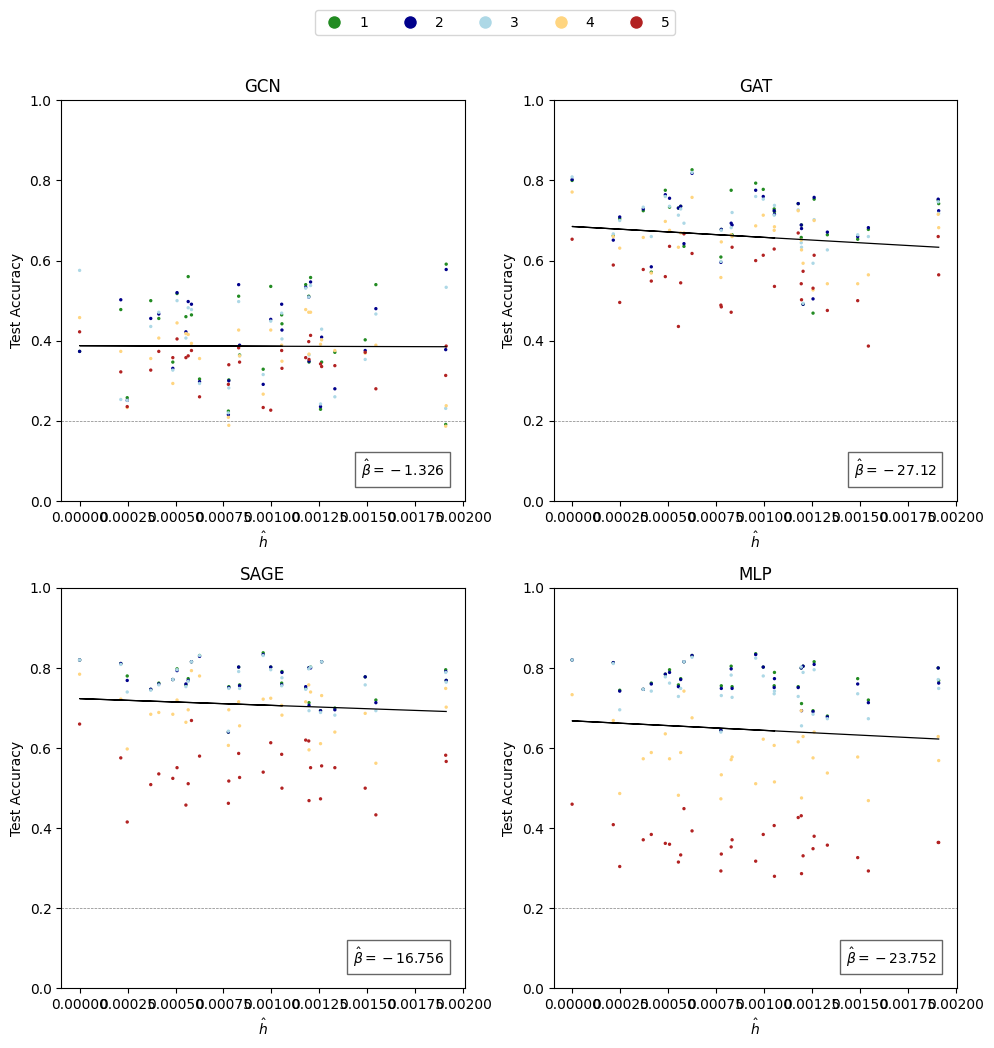

In [62]:
def plot_scatter_relation(X, y, colors, xlab, R):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    model_names = ["GCN", "GAT", "SAGE", "MLP"]

    color_labels = np.arange(1, len(colors) + 1)

    for i, ax in enumerate(axs.flatten()):

        repeated_colors = np.repeat(colors, R)
        sc = ax.scatter(X, y[i, :, :].flatten(), color=repeated_colors,s=2)
        
        coef = np.polyfit(X, y[i, :, :].flatten(), 1)  
        poly1d_fn = np.poly1d(coef)

        ax.plot(X, poly1d_fn(X), '-', color='black', linewidth=.9)  
        ax.axhline(.2, linestyle="--", color="grey", linewidth=.5)
        ax.text(0.95, 0.05, f"$\\hat{{\\beta}} = {round(coef[0], 3)}$", 
                transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
                horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6))
        
        ax.set_title(model_names[i])
        ax.set_xlabel(xlab)  
        ax.set_ylim((0,1))
        ax.set_ylabel('Test Accuracy')  


    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                           markerfacecolor=color, markersize=10) 
               for label, color in zip(color_labels, colors)]
    
    fig.legend(handles=handles, loc='upper center', ncol=len(color_labels), bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

#plot_scatter_relation(x1, Y, colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"], xlab = r"$\hat{h}$", R=100)
plot_scatter_relation(x1, Y, colors = ["forestgreen", "darkblue", "lightblue","#FFD580", "firebrick"], xlab = r"$\hat{h}$", R=30)

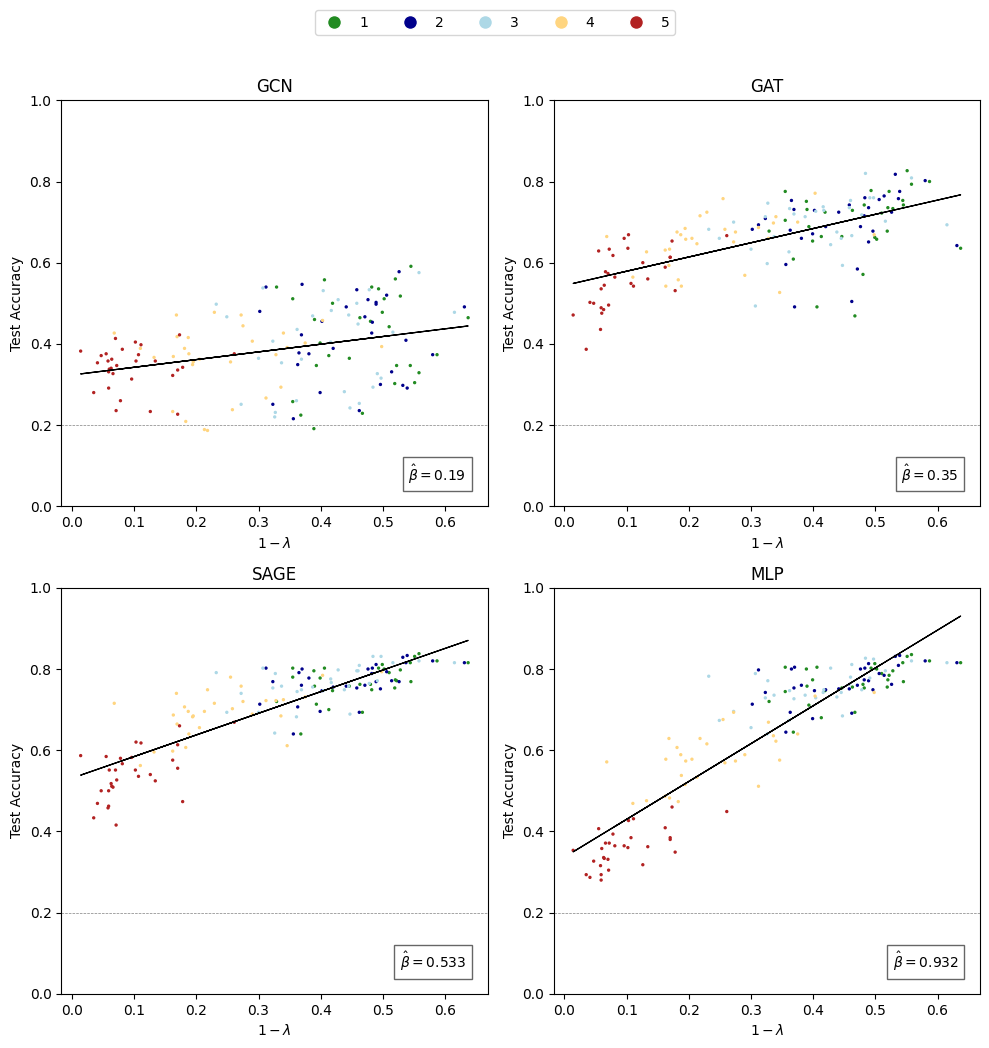

In [63]:
#plot_scatter_relation(x2, Y, colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"], xlab = r"$1 - \lambda$", R=100)

plot_scatter_relation(x2, Y, colors = ["forestgreen", "darkblue", "lightblue","#FFD580", "firebrick"], xlab = r"$1 - \lambda$", R=30)